*For in-depth explanations of the model and process please refer to the PDF write-up.*

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import pymodule.grapher as gp
from pymodule.loader import Loader
from pymodule.bootstrap import Bootstrapper
from pymodule.copula import Copula
from pymodule.transform import PseudoSampleToDefaultTimeTransformer
from pymodule.simulate import Simulate
from pymodule.price import Pricer
%matplotlib inline

Set countries and static recovery rate to 40%. 

In [2]:
countries = ["japan", "china", "thailand", "singapore", "malaysia"]
N = len(countries)
RR = 0.4
T = 5

Instantiate and fit required classes from imported custom modules.

In [3]:
loader = Loader(countries)
loader.fit()
bootstrapper = Bootstrapper(loader=loader, RR=RR)
bootstrapper.fit()
copula = Copula(loader=loader, countries=countries, N=N, display=True)
copula.fit()
simulate = Simulate(copula=copula, n_simulations=1000000, countries=countries, N=N)
transformer = PseudoSampleToDefaultTimeTransformer(N=N, bootstrapper=bootstrapper)
pricer = Pricer(RR=RR, N=N, T=T, bootstrapper=bootstrapper)

The graph below shows the historical credit spread movements for the 5 constituents. 

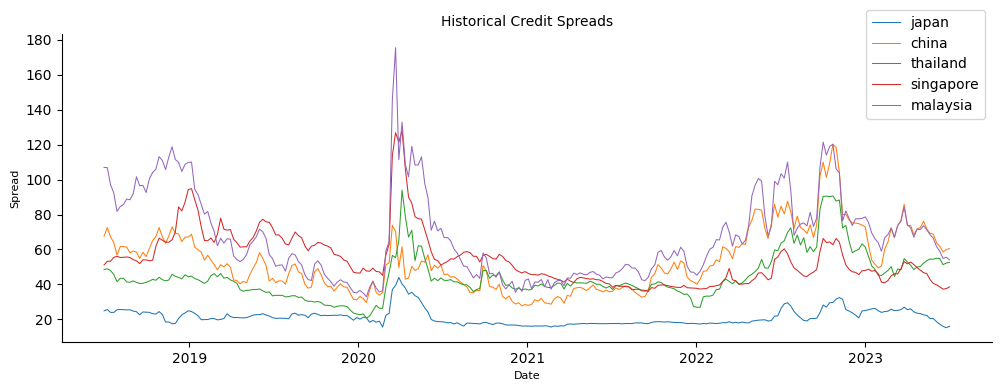

In [4]:
gp.graph(
    df=loader.df_cds_historical,
    cols=countries,
    kind=plt.plot,
    figsize=(12, 4),
    title="Historical Credit Spreads",
    xlabel="Date",
    ylabel="Spread",
    lw=0.75
)

The graph below plots the daily changes in credit spreads for the 5 constituents.

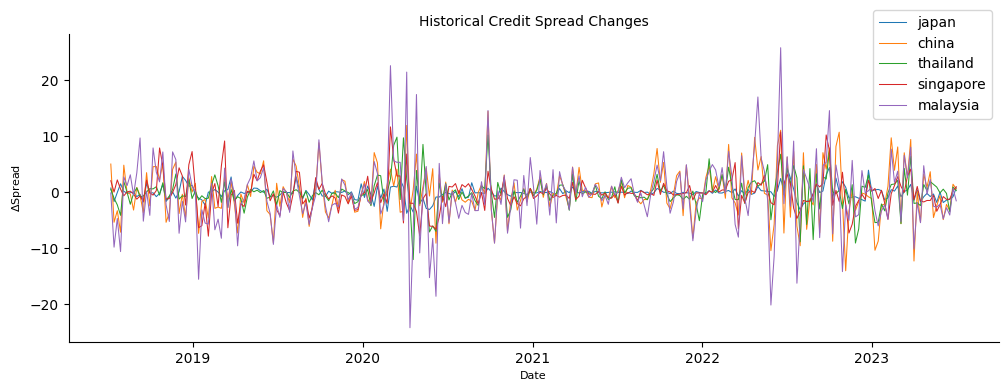

In [5]:
gp.graph(
    df=copula.df_X_hist,
    cols=countries,
    kind=plt.plot,
    figsize=(12, 4),
    title="Historical Credit Spread Changes",
    xlabel="Date",
    ylabel=r"$\Delta$Spread",
    lw=0.75
)

The graph below plots the credit curves using 1-5Y tenor points as of 6/30/23.

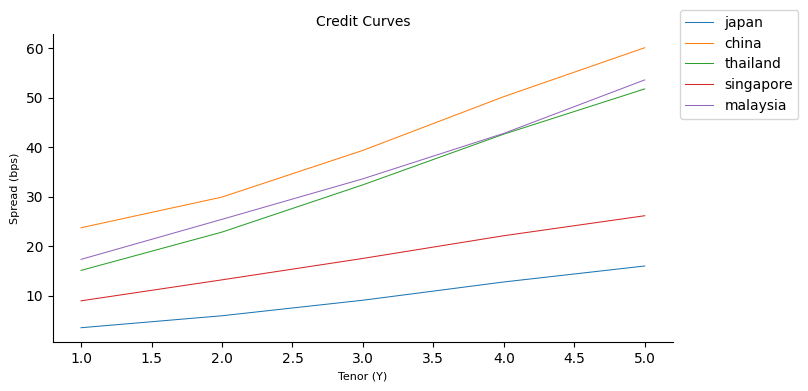

In [32]:
gp.graph(
    df=loader.df_curves * 10000,
    cols=countries,
    kind=plt.plot,
    figsize=(8, 4),
    title="Credit Curves",
    xlabel="Tenor (Y)",
    ylabel="Spread (bps)",
    lw=0.75
)

The graph below plots the log-linear interpolated discount curve using 0.25-5Y tenor points as of 6/30/23.

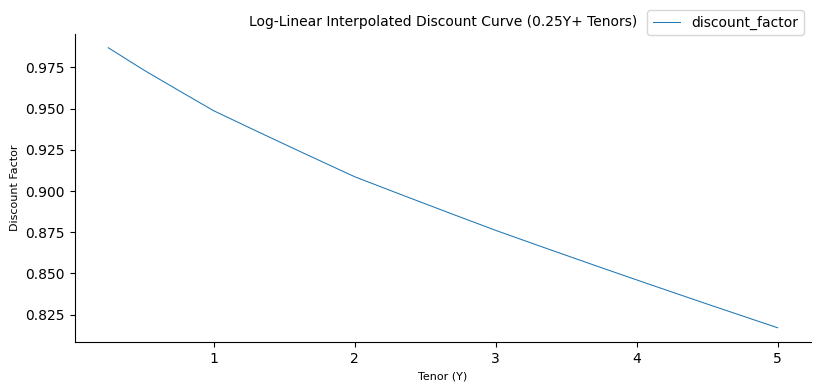

In [7]:
gp.graph(
    df=pd.DataFrame(bootstrapper.interpolated_discount_curve, index=["discount_factor"]).T,
    cols=["discount_factor"],
    kind=plt.plot,
    figsize=(9.5, 4),
    title="Log-Linear Interpolated Discount Curve (0.25Y+ Tenors)",
    xlabel="Tenor (Y)",
    ylabel="Discount Factor",
    lw=0.75
)

The graph below plots the survivial probabilities term structure bootstrapped from the credit curves.

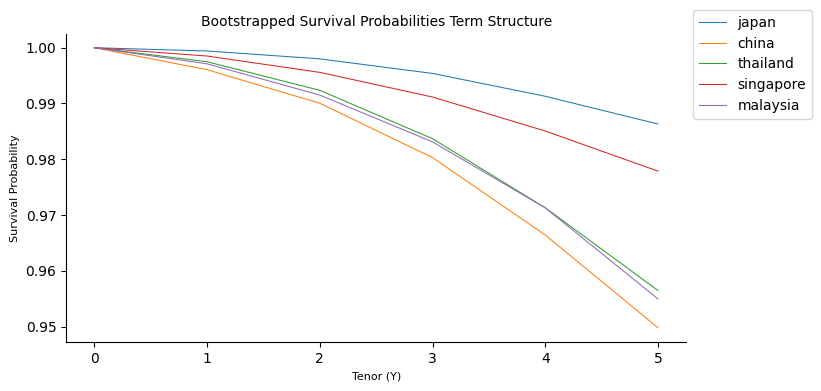

In [8]:
gp.graph(
    df=bootstrapper.df_survival_probabilities.dropna(),
    cols=countries,
    kind=plt.plot,
    figsize=(8, 4),
    title="Bootstrapped Survival Probabilities Term Structure",
    xlabel="Tenor (Y)",
    ylabel="Survival Probability",
    lw=0.75
)

The graph below plots the piecewise-constant hazard rates term structure bootstrapped from survival probabilities, a calibration to the Inhomogonous Poisson Process.

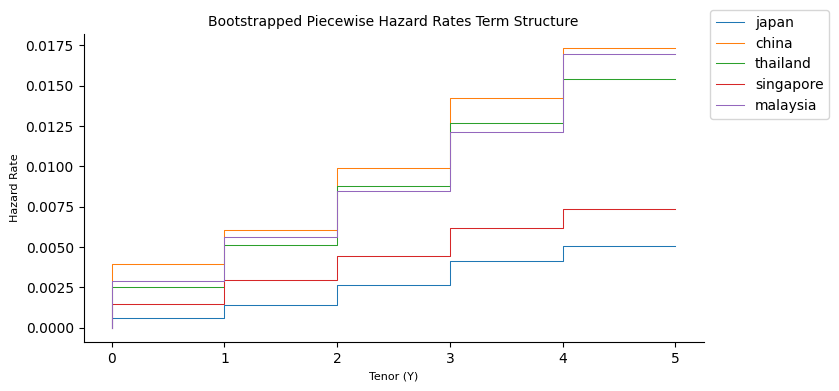

In [9]:
gp.graph(
    df=bootstrapper.df_hazard_rates.fillna(0),
    cols=countries,
    kind=plt.step,
    figsize=(8, 4),
    title="Bootstrapped Piecewise Hazard Rates Term Structure",
    xlabel="Tenor (Y)",
    ylabel="Hazard Rate",
    lw=0.75
)

The below plot reflects the pairwise relationships between changes in CDS spreads, as well as the histograms denoting the distribution of spread changes for each entity. The distributions are all non-parametric, and need to be converted to uniform distributions using a kernel smoothing method.

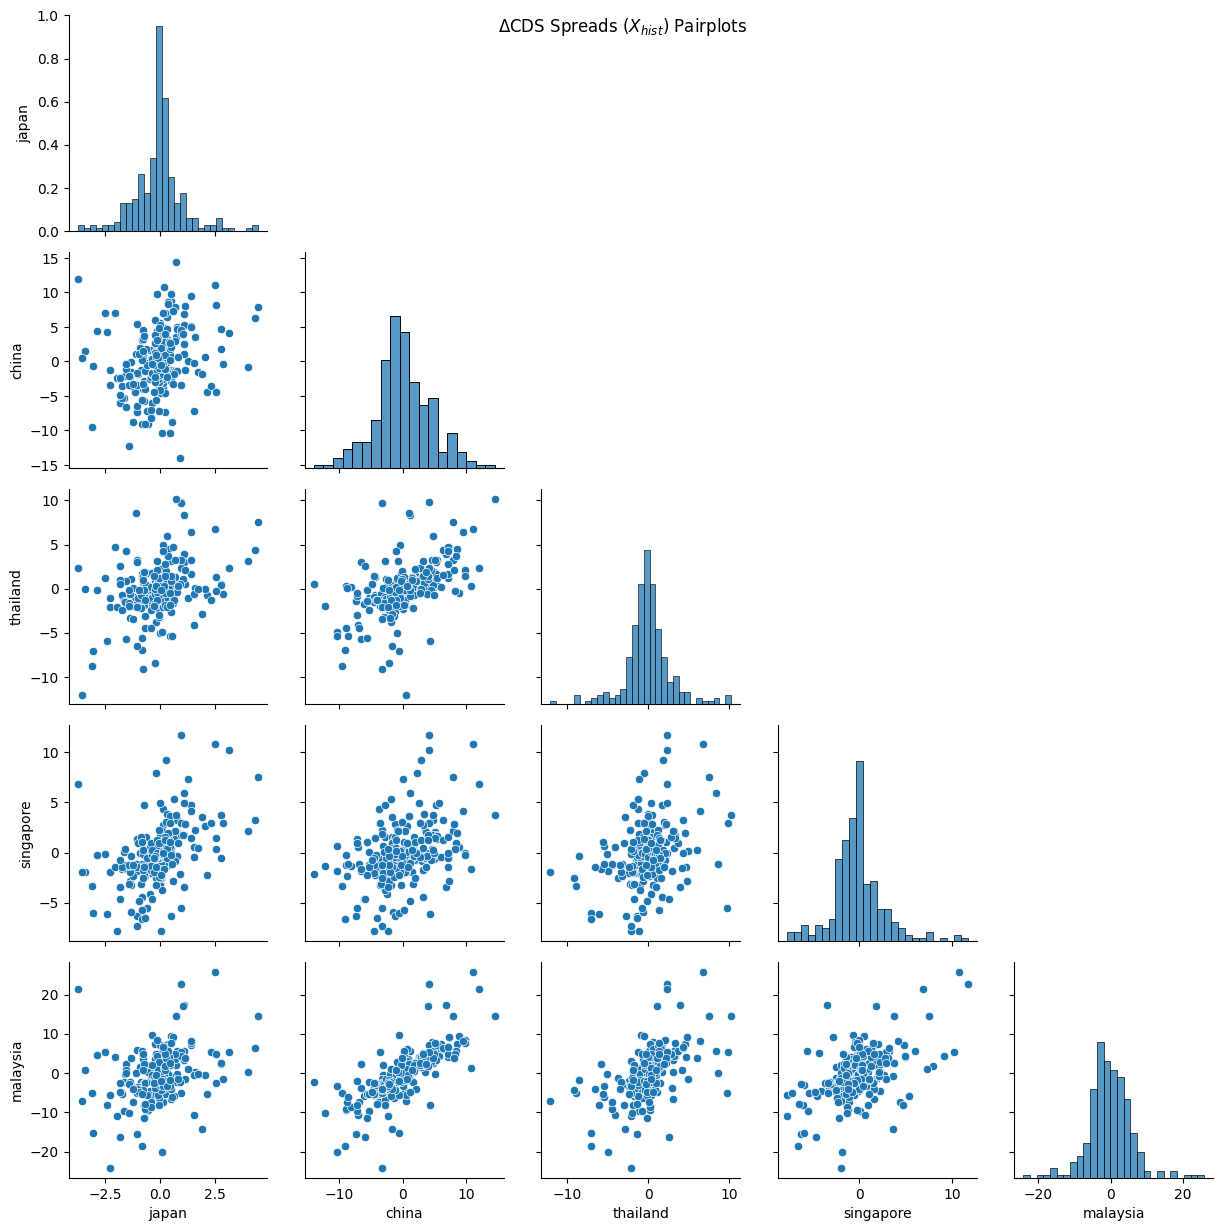

In [10]:
gp.pairplot(
    df=copula.df_X_hist, 
    title=r"$\Delta$CDS Spreads ($X_{hist}$) Pairplots"
)

The below plots reflect the same relationships and distributions after each distribution of spread changes were converted to uniform distribution using R's KS Density tools.

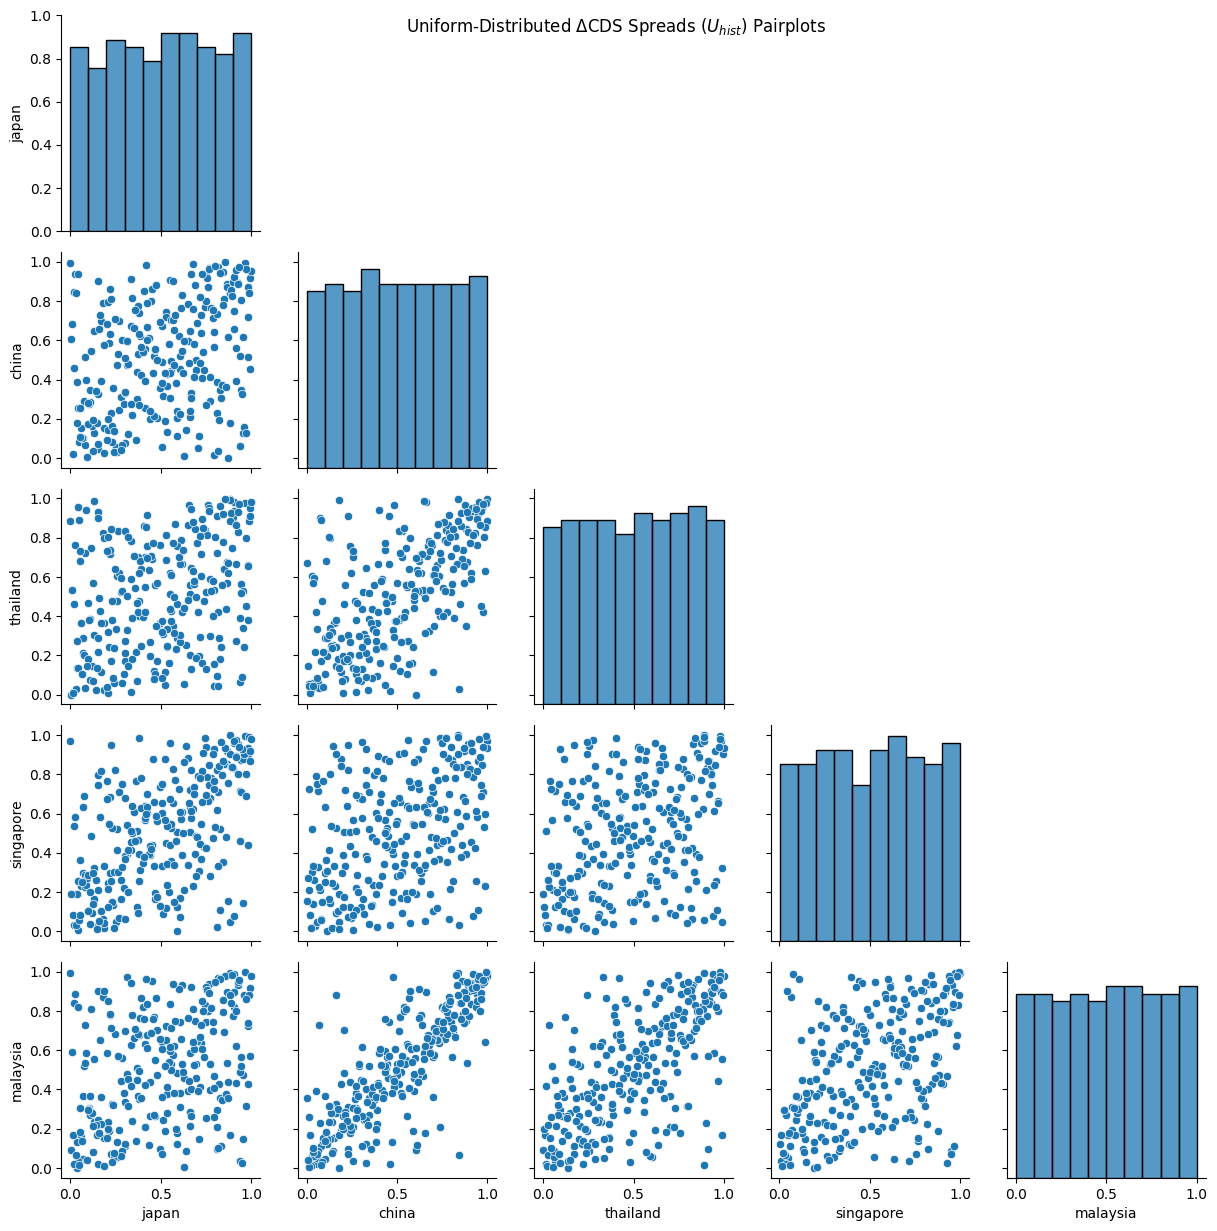

In [11]:
gp.pairplot(
    df=copula.df_U_hist, 
    title=r"Uniform-Distributed $\Delta$CDS Spreads ($U_{hist}$) Pairplots"
)

The below plots reflect the uniform distributed variables converted back to the standard normal distribution. 

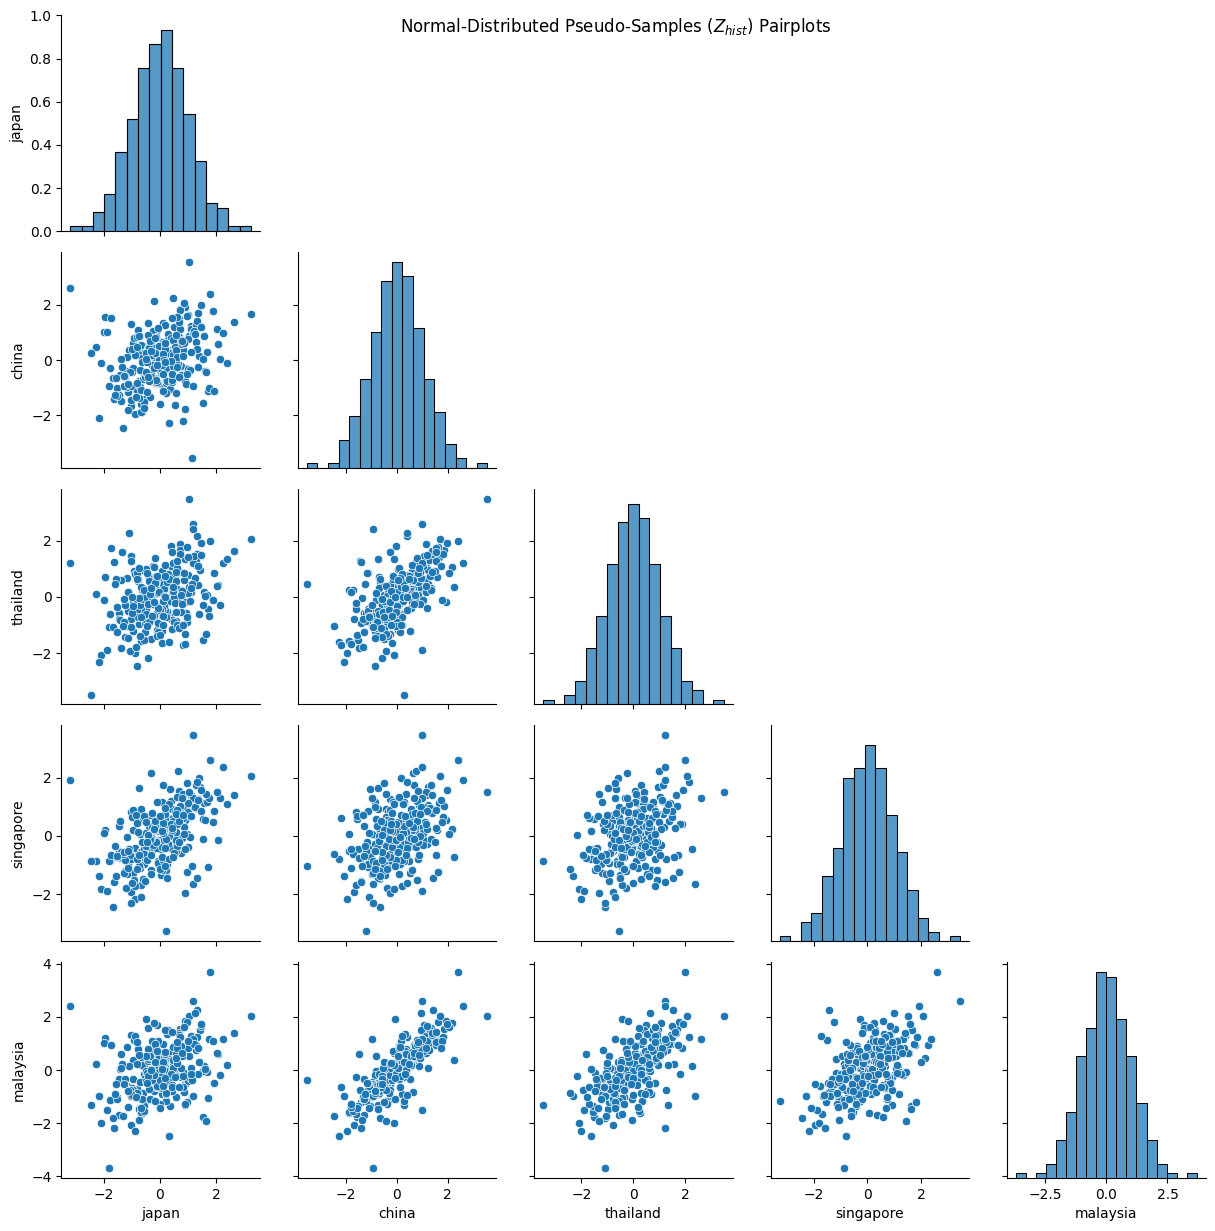

In [12]:
gp.pairplot(
    df=copula.df_Z_hist, 
    title=r"Normal-Distributed Pseudo-Samples ($Z_{hist}$) Pairplots"
)

The below 3 matrices show the Cholesky factorizations of the correlation matrices. 

In [13]:
df_gaussian_spreads = simulate.gaussian(
).pipe(
    transformer.construct_kth_to_default_times_table
).pipe(
    pricer.construct_fair_spread_table,
    distribution="gaussian"
)



#### Correlation Matrix (*Gaussian*)

,japan,china,thailand,singapore,malaysia
japan,1.000000,0.281848,0.338171,0.523443,0.359867
china,0.281848,1.000000,0.592775,0.413535,0.792661
thailand,0.338171,0.592775,1.000000,0.353977,0.616127
singapore,0.523443,0.413535,0.353977,1.000000,0.476528
malaysia,0.359867,0.792661,0.616127,0.476528,1.000000



#### Cholesky Decomposed Matrix (*Gaussian*)

,,,,,
,1.000000,0.000000,0.000000,0.000000,0.000000
,0.281848,0.959459,0.000000,0.000000,0.000000
,0.338171,0.518482,0.785377,0.000000,0.000000
,0.523443,0.277243,0.042297,0.804583,0.000000
,0.359867,0.720440,0.153933,0.101805,0.563385


Degrees of freedom calibrated to 5 for both Spearman and Kendall correlation for Student's T copula.


#### Correlation Matrix (*Student's T - Spearman*)

,japan,china,thailand,singapore,malaysia
japan,1.000000,0.340008,0.315755,0.567559,0.371533
china,0.340008,1.000000,0.641894,0.416053,0.839401
thailand,0.315755,0.641894,1.000000,0.344188,0.659404
singapore,0.567559,0.416053,0.344188,1.000000,0.460743
malaysia,0.371533,0.839401,0.659404,0.460743,1.000000



#### Cholesky Decomposed Matrix (*Student's T - Spearman*)

,,,,,
,1.000000,0.000000,0.000000,0.000000,0.000000
,0.340008,0.940423,0.000000,0.000000,0.000000
,0.315755,0.568398,0.759752,0.000000,0.000000
,0.567559,0.237211,0.039681,0.787422,0.000000
,0.371533,0.758252,0.146235,0.081541,0.508905


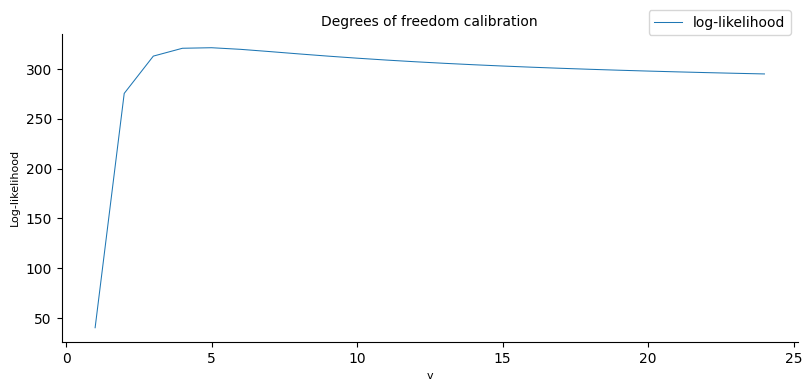

Calibrated Student's T - Spearman copula to 5 degrees of freedom


In [14]:
df_t_spearman_spreads = simulate.students_t(
    method="spearman"
).pipe(
    transformer.construct_kth_to_default_times_table
).pipe(
    pricer.construct_fair_spread_table,
    distribution="students_t_spearman"
)


#### Correlation Matrix (*Student's T - Kendall*)

,japan,china,thailand,singapore,malaysia
japan,1.000000,0.350599,0.325730,0.587066,0.381747
china,0.350599,1.000000,0.659253,0.420798,0.860950
thailand,0.325730,0.659253,1.000000,0.351383,0.678104
singapore,0.587066,0.420798,0.351383,1.000000,0.476108
malaysia,0.381747,0.860950,0.678104,0.476108,1.000000



#### Cholesky Decomposed Matrix (*Student's T - Kendall*)

,,,,,
,1.000000,0.000000,0.000000,0.000000,0.000000
,0.350599,0.936526,0.000000,0.000000,0.000000
,0.325730,0.581994,0.745106,0.000000,0.000000
,0.587066,0.229543,0.035654,0.775495,0.000000
,0.381747,0.776391,0.136763,0.088855,0.474223


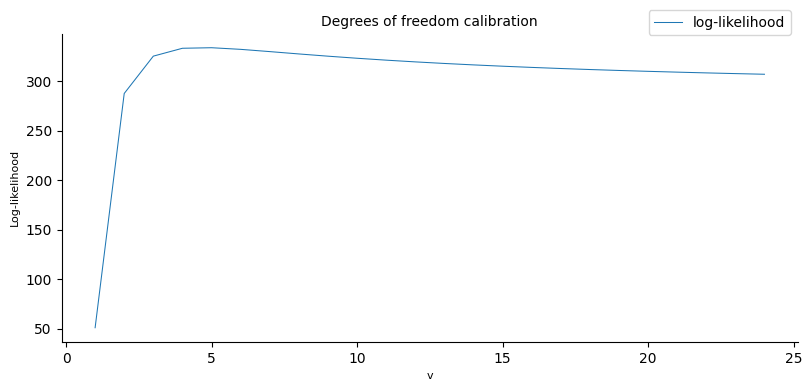

Calibrated Student's T - Kendall copula to 5 degrees of freedom


In [15]:
df_t_kendall_spreads = simulate.students_t(
    method="kendall"
).pipe(
    transformer.construct_kth_to_default_times_table
).pipe(
    pricer.construct_fair_spread_table,
    distribution="students_t_kendall"
)

In [16]:
df = pd.concat([df_gaussian_spreads, df_t_spearman_spreads, df_t_kendall_spreads])

Spread pricing table below using 1,000,000 simulations.

In [17]:
df.applymap(lambda x: str(round(x*10000, 2)) + " bps" if pd.notnull(x) else x)

1          2         3  \
distribution_type   premium_leg_spread_type                                   
gaussian            spread_without_removal   30.99 bps   9.83 bps  2.98 bps   
                    spread_with_removal            NaN   9.78 bps  2.97 bps   
students_t_spearman spread_without_removal   26.68 bps  11.38 bps  4.77 bps   
                    spread_with_removal            NaN  11.32 bps  4.76 bps   
students_t_kendall  spread_without_removal   26.14 bps  11.58 bps  4.99 bps   
                    spread_with_removal            NaN  11.52 bps  4.98 bps   

                                                    4         5  
distribution_type   premium_leg_spread_type                      
gaussian            spread_without_removal   0.52 bps  0.06 bps  
                    spread_with_removal      0.52 bps  0.06 bps  
students_t_spearman spread_without_removal   1.27 bps  0.25 bps  
                    spread_with_removal      1.27 bps  0.25 bps  
students_t_kendall  spread_without_removal   1.32 bps  0.28 bps  
                    spread_with_removal      1.32 bps  0.28 bps

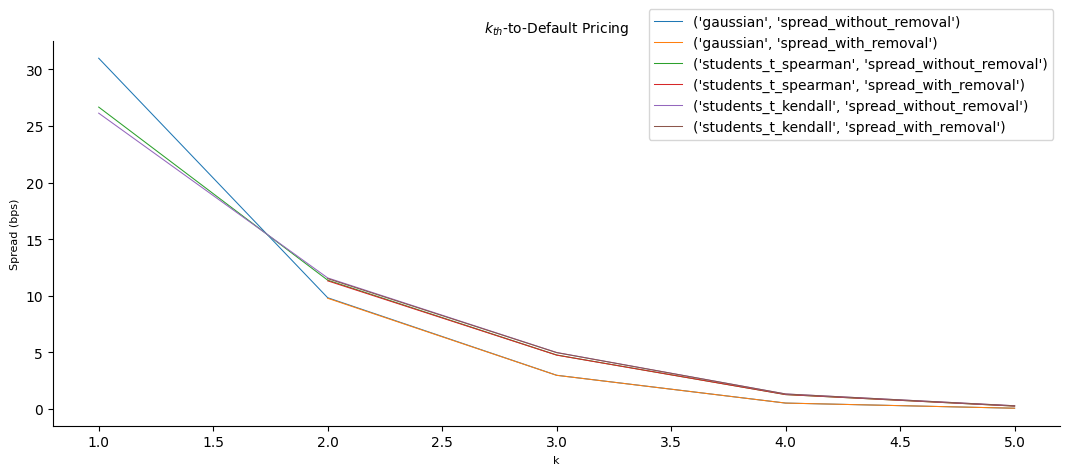

In [18]:
gp.graph(
    df=df.T * 10000,
    cols=df.T.columns,
    kind=plt.plot,
    figsize=(13, 5),
    title=r"$k_{th}$-to-Default Pricing",
    xlabel="k",
    ylabel="Spread (bps)",
    lw=0.75
)

In [19]:
loader.df_discount_curve

,zero_cpn_yield,discount_factor
tenor(y),,
0.25,0.05256,0.986946
0.50,0.05368,0.973517
1.00,0.05272,0.948646
2.00,0.04791,0.908628
3.00,0.04409,0.876104
4.00,0.04179,0.846064
5.00,0.04041,0.817054


In [20]:
t1 = 0.948646
t2 = 0.908628

In [21]:
bootstrapper.interpolated_discount_curve

{0.25: 0.9869459529143578,
 0.26: 0.9864052546970035,
 0.27: 0.9858648527011001,
 0.28: 0.9853247467643629,
 0.29: 0.9847849367245959,
 0.3: 0.9842454224196918,
 0.31: 0.9837062036876326,
 0.32: 0.9831672803664885,
 0.33: 0.9826286522944188,
 0.34: 0.9820903193096712,
 0.35: 0.9815522812505822,
 0.36: 0.981014537955577,
 0.37: 0.9804770892631689,
 0.38: 0.97993993501196,
 0.39: 0.9794030750406406,
 0.4: 0.9788665091879897,
 0.41: 0.9783302372928744,
 0.42: 0.9777942591942499,
 0.43: 0.9772585747311601,
 0.44: 0.9767231837427365,
 0.45: 0.9761880860681993,
 0.46: 0.9756532815468565,
 0.47: 0.975118770018104,
 0.48: 0.974584551321426,
 0.49: 0.9740506252963943,
 0.5: 0.973516991782669,
 0.51: 0.9730132297725774,
 0.52: 0.9725097284422325,
 0.53: 0.9720064876567414,
 0.54: 0.9715035072812809,
 0.55: 0.9710007871810976,
 0.56: 0.9704983272215081,
 0.57: 0.9699961272678982,
 0.58: 0.9694941871857238,
 0.59: 0.9689925068405103,
 0.6: 0.9684910860978524,
 0.61: 0.9679899248234148,
 0.62: 0.96

In [22]:
interpolated_discount_curve

NameError: name 'interpolated_discount_curve' is not defined